# Import and Environment Setup

In [311]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

# Data Import

In [312]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
all_data = pd.concat([data, test], ignore_index=True)
# display information about datasets
print('Number of Training Examples = {}'.format(data.shape[0]))
print('Number of Test Examples = {}\n'.format(test.shape[0]))
print('Training X Shape = {}'.format(data.shape))
print('Training y Shape = {}\n'.format(data['Transported'].shape[0]))
print('Test X Shape = {}'.format(test.shape))
print('Test y Shape = {}\n'.format(test.shape[0]))
print(data.columns)
print(test.columns)
print(data.info())
print(data.describe())
data.sample(5)


Number of Training Examples = 8693
Number of Test Examples = 4277

Training X Shape = (8693, 14)
Training y Shape = 8693

Test X Shape = (4277, 13)
Test y Shape = 4277

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')
Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           851

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
4838,5162_01,Mars,True,F/988/S,55 Cancri e,16.0,False,0.0,0.0,0.0,0.0,0.0,Hoce Barne,True
6020,6367_02,Mars,False,F/1215/S,55 Cancri e,18.0,False,114.0,131.0,927.0,0.0,0.0,Cank Botte,True
509,0547_01,Earth,False,F/97/S,TRAPPIST-1e,23.0,False,0.0,15.0,831.0,16.0,3.0,Trick Weavesend,False
1057,1130_02,Mars,False,D/38/S,55 Cancri e,20.0,False,NaN,3.0,3505.0,199.0,17.0,Camonk Cako,True
2228,2385_01,Mars,False,F/461/S,TRAPPIST-1e,23.0,False,1773.0,0.0,78.0,0.0,3.0,Jacats Pité,False


# Correlation Matrix

C:\Users\MJ\AppData\Local\Temp\ipykernel_14076\2224335950.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)


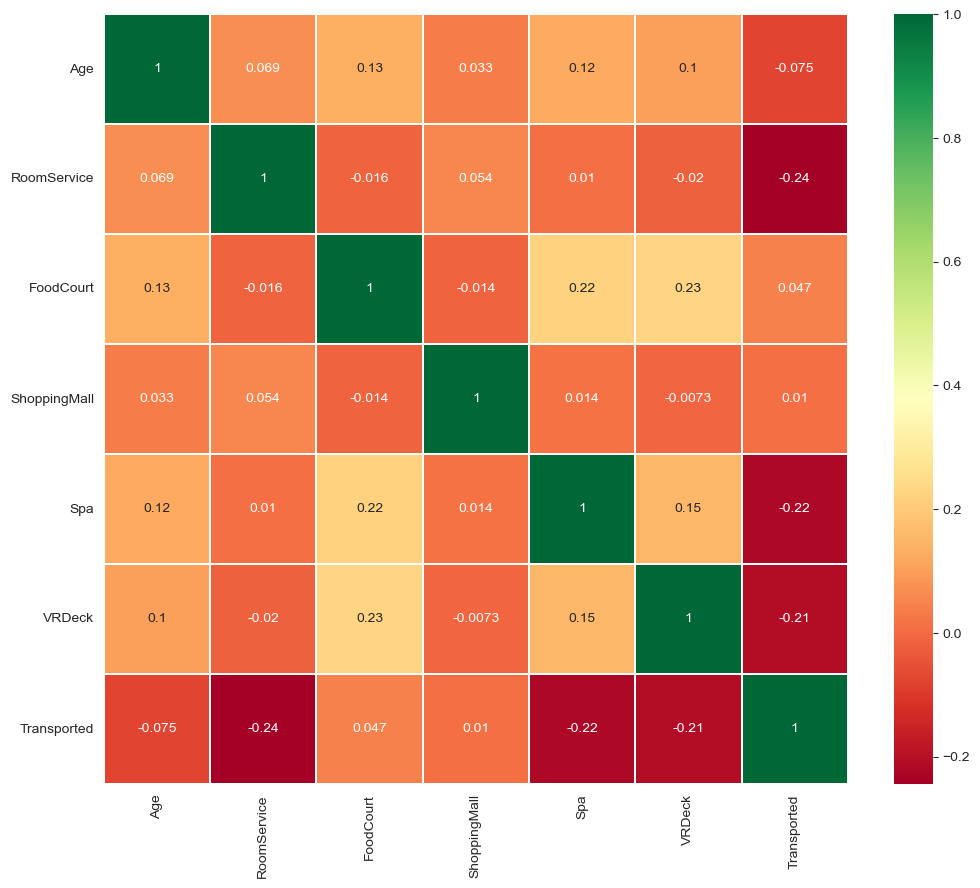

In [313]:
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.show()

# Version 1 Data Preprocessing

In [314]:
v1_data = data.copy(deep=True)
# separate PassengerId  to two columns group and number (before and after the _) as int
v1_data['Group'], v1_data['Number'] = v1_data['PassengerId'].str.split('_', 1).str
v1_data['Group'] = v1_data['Group'].astype(int)
v1_data['Number'] = v1_data['Number'].astype(int)
# drop PassengerId
v1_data.drop(['PassengerId'], axis=1, inplace=True)
# count number of members in each group
v1_data['GroupSize'] = v1_data.groupby('Group')['Group'].transform('count')

C:\Users\MJ\AppData\Local\Temp\ipykernel_14076\297776605.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  v1_data['Group'], v1_data['Number'] = v1_data['PassengerId'].str.split('_', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_14076\297776605.py:3: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  v1_data['Group'], v1_data['Number'] = v1_data['PassengerId'].str.split('_', 1).str


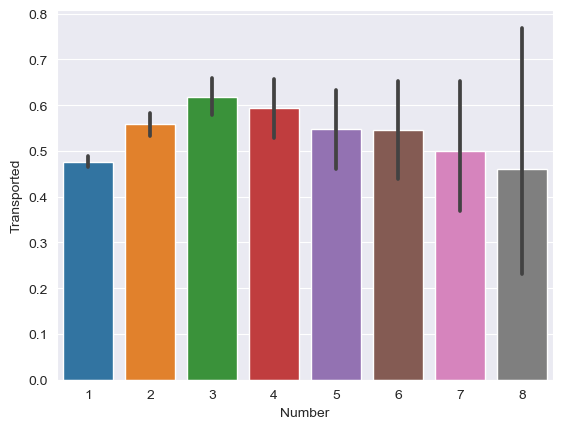

In [315]:
#Relationship between Number and Transported by percentage
sns.barplot(x='Number', y='Transported', data=v1_data)
plt.show()

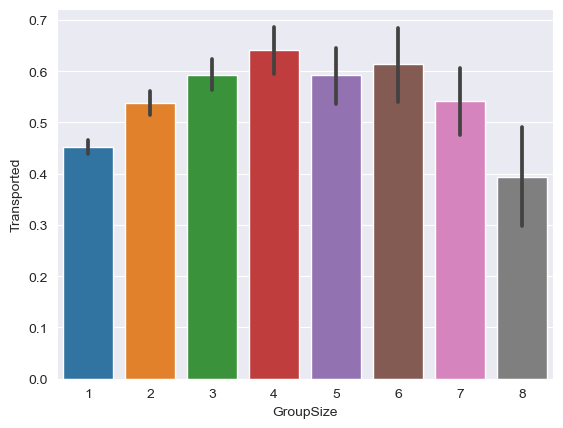

In [316]:
#Relationship between GroupSize and Transported by percentage
sns.barplot(x='GroupSize', y='Transported', data=v1_data)
plt.show()

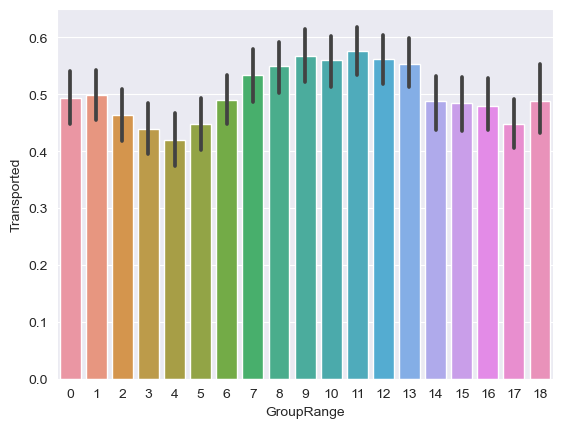

In [317]:
#Relationship between GroupRange (each 500 e.g. 1-500, 501-1000, etc.) and Transported by percentage
v1_data['GroupRange'] = v1_data['Group'].apply(lambda x: x//500)
sns.barplot(x='GroupRange', y='Transported', data=v1_data)
plt.show()

<Axes: xlabel='HomePlanet', ylabel='count'>

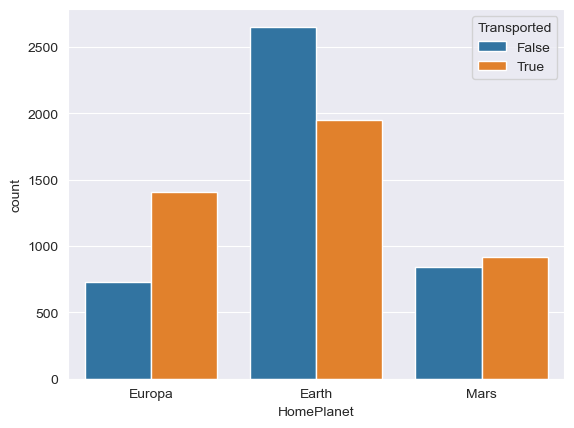

In [318]:
#Relationship between HomePlanet and Transported
sns.countplot(x='HomePlanet', hue='Transported', data=v1_data)

In [319]:
#checking if there are peoples with the same "Group" and different "HomePlanet" and print
grouped = v1_data.groupby('Group')['HomePlanet'].nunique().to_frame()
grouped[grouped['HomePlanet'] > 1]

,HomePlanet
Group,


In [320]:
v1_data[v1_data['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange
59,NaN,True,E/3/S,TRAPPIST-1e,33.0,False,0.0,0.0,NaN,0.0,0.0,Colatz Keen,True,64,2,2,0
113,NaN,False,A/0/P,TRAPPIST-1e,39.0,False,0.0,2344.0,0.0,65.0,6898.0,Batan Coning,False,119,1,2,0
186,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,210,1,1,0
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8515,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False,9084,1,1,18
8613,NaN,False,E/603/S,55 Cancri e,53.0,False,0.0,4017.0,0.0,13.0,3147.0,NaN,False,9194,1,2,18
8666,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True,9248,1,1,18
8674,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,9257,1,1,18


There are no people in the same group with different HomePlanet
so we can fill some of the missing values in HomePlanet with the HomePlanet of the other members in the same group


In [321]:

group_dict = {}
for index, row in v1_data.iterrows():
    group = row['Group']
    home_planet = row['HomePlanet']
    if pd.isnull(group) or pd.isnull(home_planet):
        continue
    group_dict[group] = home_planet
for index, row in v1_data.iterrows():
    group = row['Group']
    home_planet = row['HomePlanet']
    if pd.isnull(home_planet) and group in group_dict:
        v1_data.at[index, 'HomePlanet'] = group_dict[group]

In [322]:
v1_data[v1_data['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange
186,NaN,True,D/6/P,55 Cancri e,24.0,False,0.0,0.0,NaN,0.0,0.0,Arraid Inicont,True,210,1,1,0
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0
274,NaN,True,G/41/S,TRAPPIST-1e,23.0,False,0.0,0.0,0.0,0.0,0.0,Oraryn Kirklander,True,303,1,1,0
286,NaN,True,G/42/S,PSO J318.5-22,35.0,False,0.0,0.0,0.0,0.0,0.0,Adriet Valezaley,True,315,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8468,NaN,True,F/1848/P,TRAPPIST-1e,25.0,False,0.0,0.0,0.0,0.0,0.0,Cobix Erle,True,9043,1,1,18
8515,NaN,False,E/582/P,TRAPPIST-1e,25.0,False,1258.0,0.0,22.0,19.0,0.0,Jurs Mone,False,9084,1,1,18
8666,NaN,False,F/1792/S,55 Cancri e,38.0,NaN,28.0,1208.0,973.0,207.0,0.0,Gian Perle,True,9248,1,1,18
8674,NaN,False,F/1892/P,TRAPPIST-1e,13.0,False,39.0,0.0,1085.0,24.0,0.0,Ties Apple,False,9257,1,1,18


By searching some of the family names we can see that people with the same family name are from the same HomePlanet
so we can fill the missing values in HomePlanet with the HomePlanet of the other members in the same family (make

In [323]:
v1_data['FirstName'], v1_data['LastName'] = v1_data['Name'].str.split(' ', 1).str

last_name_dict = {}

for index, row in v1_data.iterrows():
    last_name = row['LastName']
    home_planet = row['HomePlanet']
    if pd.isnull(last_name) or pd.isnull(home_planet):
        continue
    last_name_dict[last_name] = home_planet

for index, row in v1_data.iterrows():
    last_name = row['LastName']
    home_planet = row['HomePlanet']

    if pd.isnull(home_planet) and last_name in last_name_dict:
        v1_data.at[index, 'HomePlanet'] = last_name_dict[last_name]

C:\Users\MJ\AppData\Local\Temp\ipykernel_14076\2165444582.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  v1_data['FirstName'], v1_data['LastName'] = v1_data['Name'].str.split(' ', 1).str
C:\Users\MJ\AppData\Local\Temp\ipykernel_14076\2165444582.py:1: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  v1_data['FirstName'], v1_data['LastName'] = v1_data['Name'].str.split(' ', 1).str


In [324]:
v1_data[v1_data['HomePlanet'].isnull()]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Number,GroupSize,GroupRange,FirstName,LastName
225,NaN,False,F/46/S,TRAPPIST-1e,18.0,False,313.0,1.0,691.0,283.0,0.0,Almone Sté,False,242,1,1,0,Almone,Sté
234,NaN,True,C/11/S,55 Cancri e,54.0,False,0.0,0.0,0.0,0.0,0.0,Diphah Amsive,True,251,1,1,0,Diphah,Amsive
807,NaN,True,A/9/S,55 Cancri e,38.0,False,0.0,0.0,0.0,0.0,0.0,Hamelik Ageurante,True,853,1,1,1,Hamelik,Ageurante
1855,NaN,True,G/311/S,TRAPPIST-1e,19.0,False,0.0,0.0,0.0,0.0,0.0,NaN,True,1978,1,1,3,NaN,NaN
2274,NaN,False,D/72/P,TRAPPIST-1e,31.0,False,1458.0,421.0,76.0,0.0,0.0,NaN,False,2443,1,1,4,NaN,NaN
2631,NaN,False,F/584/P,TRAPPIST-1e,25.0,False,237.0,0.0,910.0,0.0,12.0,Sealfs Sutty,False,2817,1,1,5,Sealfs,Sutty
3091,NaN,False,F/631/S,TRAPPIST-1e,40.0,False,666.0,4.0,83.0,0.0,50.0,NaN,True,3331,1,1,6,NaN,NaN
4548,NaN,True,F/915/S,TRAPPIST-1e,36.0,False,0.0,0.0,NaN,0.0,0.0,NaN,True,4840,1,1,9,NaN,NaN
5252,NaN,False,E/365/S,TRAPPIST-1e,34.0,False,170.0,1256.0,0.0,3926.0,7121.0,Kocha Cluitty,False,5603,1,1,11,Kocha,Cluitty
5634,NaN,False,F/1141/S,TRAPPIST-1e,20.0,False,0.0,0.0,NaN,703.0,0.0,Darrie Holcompton,False,5989,1,1,11,Darrie,Holcompton


good, only 12 missing values left.
for now, we will leave the rest of the missing values in HomePlanet as is and will come back to it later

<Axes: xlabel='CryoSleep', ylabel='Transported'>

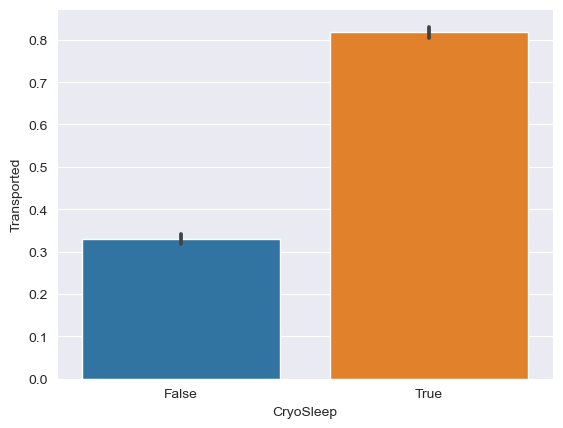

In [325]:
#Relationship between CryoSleep and Transported by percentage (not null)
sns.barplot(x='CryoSleep', y='Transported', data=v1_data[v1_data['CryoSleep'].notnull()])


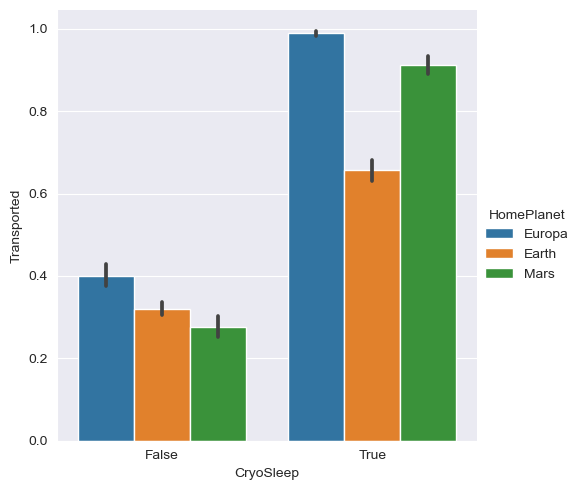

In [326]:
#Relationship between CryoSleep, HomePlanet and Transported by percentage
sns.catplot(x='CryoSleep', y='Transported', hue='HomePlanet', kind='bar', data=v1_data)


In [327]:
# Percentage of Transported by HomePlanet and CryoSleep
v1_data.groupby(['HomePlanet', 'CryoSleep'])['Transported'].mean().to_frame()

Transported
HomePlanet CryoSleep             
Earth      False         0.320340
           True          0.656738
Europa     False         0.400339
           True          0.989282
Mars       False         0.277052
           True          0.912917

some good information found we need to separate the HomePlanet into 3 different columns

In [328]:
dummies = pd.get_dummies(v1_data['HomePlanet'])
v1_data = pd.concat([v1_data, dummies], axis=1)